In [ ]:
import json
import math
import numpy as np

# Path to your calibration file and output transforms.json
INPUT_JSON = "calibration_dome.json"   
OUTPUT_JSON = "transforms.json"
# You can adjust bounding-box scale for Instant-NGP. 16 or 32 is common.
AABB_SCALE = 32

def convert_world2cam_to_nerf(world2cam, cam_id):
    """
    Given a 4x4 matrix (world->camera, left-handed, x=left,y=down,z=forward),
    convert to a 4x4 matrix (camera->world, right-handed, x=right,y=up,z=forward).
    """
    M = np.array(world2cam, dtype=np.float64).reshape(4,4)
    # Save the original translation
    original_translation = M[:3, 3]
    
    # 1) Invert to get camera->world
    cam2world = np.linalg.inv(M)
    
    # 2) Flip X (left->right-handed). (x,y,z)->(-x,+y,+z)
    flip = np.diag([1, -1, 1, 1])
    cam2world_nerf = flip @ cam2world
    
    # Save the new translation
    new_translation = cam2world_nerf[:3, 3]
    
    # Debugging: Print the original and transformed translation components
    print(f"Original Translation for Camera {cam_id}:\n{original_translation}")
    print(f"Transformed Translation for Camera {cam_id}:\n{new_translation}")
    
    return cam2world_nerf

def camera_angle_in_radians(image_size, focal_length):
    """
    angle = 2 * arctan( (image_size/2) / focal_length )
    Return in radians.
    """
    return 2.0 * math.atan((image_size / 2) / focal_length)

def main():
    with open(INPUT_JSON, "r") as f:
        data = json.load(f)
    
    # We'll build the final transforms dict for NeRF
    transforms_dict = {
        "aabb_scale": AABB_SCALE,
        "frames": []
    }
    
    # Loop through each camera in the "cameras" array
    for cam in data["cameras"]:
        cam_id = cam["camera_id"]
        # --- EXTRINSICS ---
        # world->camera matrix from the JSON
        world2cam = cam["extrinsics"]["view_matrix"]  # 16 floats, row-major
        # Convert it to camera->world, right-handed
        transform_matrix = convert_world2cam_to_nerf(world2cam, cam_id)
        
        # --- INTRINSICS ---
        # camera_matrix = [ fx, 0, cx,  0, fy, cy,  0, 0, 1 ]
        cm = cam["intrinsics"]["camera_matrix"]
        fx = cm[0]
        fy = cm[4]
        cx = cm[2]
        cy = cm[5]
        # resolution = [ w, h ]
        w, h = cam["intrinsics"]["resolution"]
        # Distortions all zero:
        k1 = k2 = k3 = k4 = 0
        p1 = p2 = 0
        # (Optional) Compute camera_angle_x / camera_angle_y in radians
        # Then FOV in degrees if you want
        angle_x = camera_angle_in_radians(w, fx)
        angle_y = camera_angle_in_radians(h, fy)
        fovx_deg = math.degrees(angle_x)
        fovy_deg = math.degrees(angle_y)
        # Build a "frame" entry in the transforms.json style
        frame = {
            "file_path": f"./images/{cam_id}.jpg",  # or however you map ID -> filename
            "transform_matrix": transform_matrix.tolist(),  # 2D list for JSON
            "w": float(w),
            "h": float(h),
            "fl_x": float(fx),
            "fl_y": float(fy),
            "cx": float(cx),
            "cy": float(cy),
            # zero out distortion
            "k1": k1,
            "k2": k2,
            "k3": k3,
            "k4": k4,
            "p1": p1,
            "p2": p2,
            "is_fisheye": False,
            # optional fields
            "camera_angle_x": angle_x,
            "camera_angle_y": angle_y,
            "fovx": fovx_deg,
            "fovy": fovy_deg,
            # you can store extra metadata if desired
            "sharpness": 1.0
        }
        transforms_dict["frames"].append(frame)
    
    # Write out to transforms.json
    with open(OUTPUT_JSON, "w") as f:
        json.dump(transforms_dict, f, indent=2)
    
    print(f"Done. Wrote {OUTPUT_JSON} with {len(transforms_dict['frames'])} frames.")

if __name__ == "__main__":
    main()

Original Translation for Camera C0000:
[-0.42149337  2.50648142  2.87779336]
Transformed Translation for Camera C0000:
[-0.99589507  2.36220979  2.8583139 ]
Original Translation for Camera C0001:
[-0.78282517 -0.26205656  4.95332103]
Transformed Translation for Camera C0001:
[0.8785341  0.05969808 4.94383375]
Original Translation for Camera C0004:
[ 0.00000000e+00 -7.67842390e-49 -9.86076132e-32]
Transformed Translation for Camera C0004:
[-8.27533837e-65 -7.67842390e-49  9.86076132e-32]
Original Translation for Camera C0005:
[-0.48724851 -1.07722496  4.66642586]
Transformed Translation for Camera C0005:
[-0.55555362 -1.42601637  4.56412012]
Original Translation for Camera C0006:
[-0.11756095 -2.09667372  1.34079208]
Transformed Translation for Camera C0006:
[-0.13159296 -2.20624995  1.15009962]
Original Translation for Camera C0007:
[-0.12969891  2.17775711  1.20248831]
Transformed Translation for Camera C0007:
[-0.1829866   2.10812127  1.31444535]
Original Translation for Camera C0008

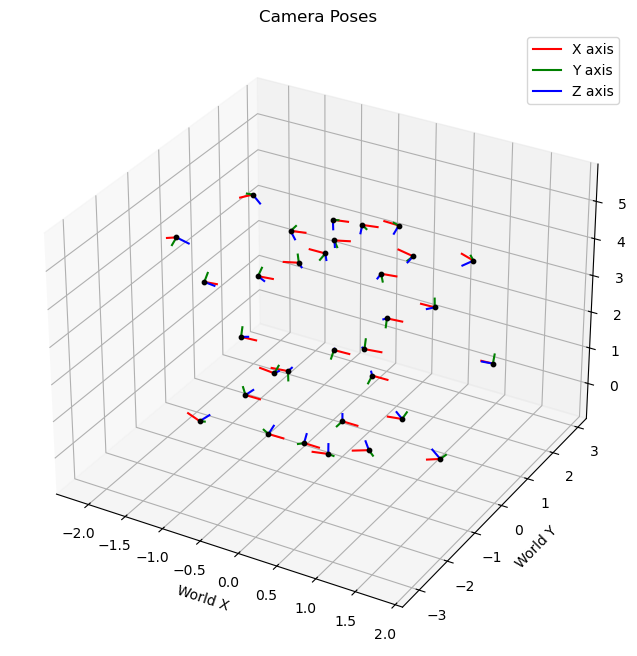

In [1]:
# JUPYTER NOTEBOOK CELL

%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to your transforms.json
TRANSFORMS_JSON = "transforms.json"
def plot_camera(ax, transform, scale=0.2):
    """
    Plot a single camera pose as a small coordinate frame:
      - transform: 4x4 camera->world matrix
      - scale: length of each local axis line
    No per-camera text is displayed.
    """
    M = np.array(transform, dtype=np.float64).reshape(4, 4)

    # Camera center in world coords = M * [0, 0, 0, 1]
    cam_center = M @ np.array([0, 0, 0, 1])
    cx, cy, cz, _ = cam_center

    # Directions of local x, y, z axes in world coords
    x_end = M @ np.array([scale, 0,      0,      1])
    y_end = M @ np.array([0,      scale, 0,      1])
    z_end = M @ np.array([0,      0,      scale, 1])

    # Convert to offsets relative to camera center
    x_vec = x_end[:3] - cam_center[:3]
    y_vec = y_end[:3] - cam_center[:3]
    z_vec = z_end[:3] - cam_center[:3]

    # Plot lines for each axis (no text labels)
    ax.plot([cx, cx + x_vec[0]], [cy, cy + x_vec[1]], [cz, cz + x_vec[2]], color='red')
    ax.plot([cx, cx + y_vec[0]], [cy, cy + y_vec[1]], [cz, cz + y_vec[2]], color='green')
    ax.plot([cx, cx + z_vec[0]], [cy, cy + z_vec[1]], [cz, cz + z_vec[2]], color='blue')

    # Mark the camera center as a black dot
    ax.scatter(cx, cy, cz, color='k', s=10)


# --- LOAD THE TRANSFORMS.JSON ---
with open(TRANSFORMS_JSON, "r") as f:
    data = json.load(f)

frames = data["frames"]  # list of camera entries

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.set_title("Camera Poses")

# Draw "dummy" lines for the legend
# (we won't label each camera's axes individually,
#  just have a single entry for X=red, Y=green, Z=blue)
ax.plot([], [], [], color='red',  label='X axis')
ax.plot([], [], [], color='green',label='Y axis')
ax.plot([], [], [], color='blue', label='Z axis')
ax.legend()

# Plot each camera (with no text about images)
for frame in frames:
    T = frame["transform_matrix"]  # 4x4 camera->world
    plot_camera(ax, T, scale=0.2)

# Auto-scale the axes to fit all cameras
all_points = []
for frame in frames:
    M = np.array(frame["transform_matrix"], dtype=float)
    c = M @ np.array([0, 0, 0, 1])  # camera center
    all_points.append(c[:3])
all_points = np.array(all_points)
if len(all_points) > 0:
    mins = all_points.min(axis=0)
    maxs = all_points.max(axis=0)
    pad = 0.2 * (maxs - mins)  # 20% padding
    mins -= pad
    maxs += pad
    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

# Label global axes
ax.set_xlabel("World X")
ax.set_ylabel("World Y")
ax.set_zlabel("World Z")

plt.show()


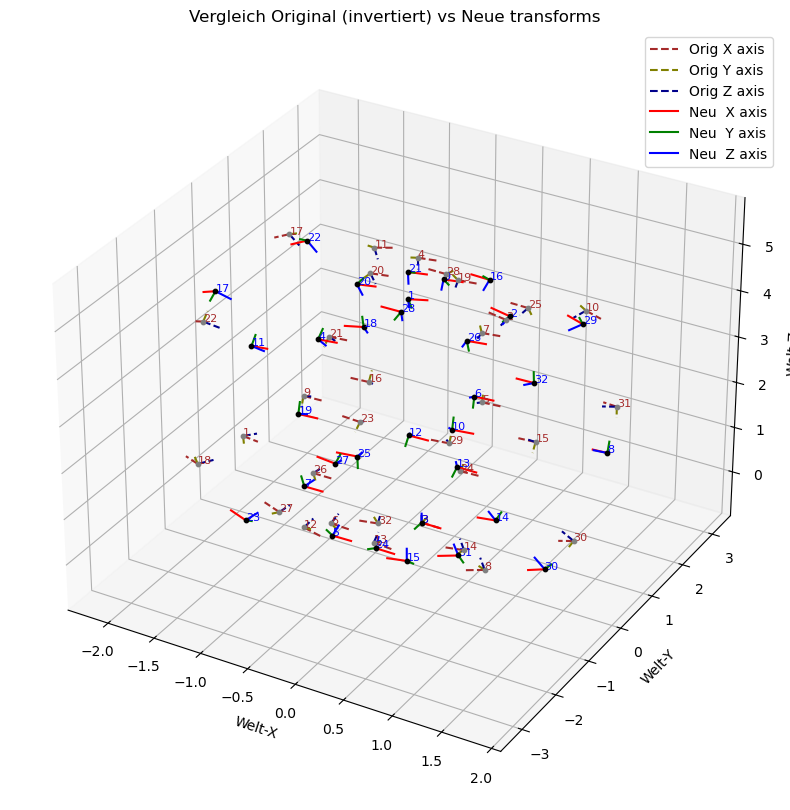

In [2]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt

# Pfade zum Beispiel
ORIGINAL_FILE = "calibration_dome.json"  # Enthält "cameras" (world->camera)
TRANSFORMED_FILE = "transforms.json"     # Enthält "frames" (camera->world)

def load_original_calibration(path, invert=True):
    """
    Lädt eine 'alte' Kalibrierungsdatei mit Key "cameras",
    deren extrinsics["view_matrix"] = world->camera.
    Gibt eine Liste "frames" zurück, in der jeder Eintrag ein dict {"transform_matrix": ...}
      - Falls 'invert=True', wird die Matrix invertiert (camera->world).
    """
    with open(path, "r") as f:
        data = json.load(f)
    cams = data["cameras"]  # Liste von Kameras

    frames_out = []
    for cam in cams:
        w2c = np.array(cam["extrinsics"]["view_matrix"], dtype=np.float64).reshape(4,4)
        if invert:
            c2w = np.linalg.inv(w2c)
            transform = c2w
        else:
            transform = w2c

        frames_out.append({"transform_matrix": transform})

    return frames_out

def load_transforms_json(path):
    """
    Lädt eine 'transforms.json'-Datei mit Key "frames",
    wo jedes Frame "transform_matrix" (camera->world) enthält.
    """
    with open(path, "r") as f:
        data = json.load(f)
    frames = data["frames"]

    frames_out = []
    for fr in frames:
        T = np.array(fr["transform_matrix"], dtype=np.float64).reshape(4,4)
        frames_out.append({"transform_matrix": T})
    return frames_out

def plot_cameras(ax, frames, scale=0.2, 
                 colorX="red", colorY="green", colorZ="blue", 
                 marker_color="black", linestyle="-", label_prefix="",
                 enumerate_cameras=False, text_color="black", text_fontsize=8):
    """
    Zeichnet alle Kameras aus 'frames' in ein 3D-Plot.
    frames: Liste von dicts {"transform_matrix": 4x4 camera->world}
    scale: Länge der lokalen Achsen
    colorX/Y/Z: Farben der Achsen
    marker_color: Farbe für den Kamera-Punkt
    linestyle: z.B. '-' (durchgezogen) oder '--' (gestrichelt)
    label_prefix: z.B. 'Orig' oder 'Neu' für die Legende
    enumerate_cameras: True => neben jeder Kamera wird eine kleine Zahl gezeichnet
    text_color, text_fontsize: Aussehen der Kameranummern
    """
    for i, frame in enumerate(frames, start=1):
        M = frame["transform_matrix"]
        # Kamerazentrum im Weltkoordinatensystem
        c_cam = M @ np.array([0,0,0,1])
        cx, cy, cz = c_cam[:3]

        # Lokale X-,Y-,Z-Achsen => absolute Weltkoords
        x_end = M @ np.array([scale, 0, 0, 1])
        y_end = M @ np.array([0, scale, 0, 1])
        z_end = M @ np.array([0, 0, scale, 1])

        x_vec = x_end[:3] - c_cam[:3]
        y_vec = y_end[:3] - c_cam[:3]
        z_vec = z_end[:3] - c_cam[:3]

        # Plot Achsen
        ax.plot([cx, cx + x_vec[0]], [cy, cy + x_vec[1]], [cz, cz + x_vec[2]], 
                color=colorX, linestyle=linestyle)
        ax.plot([cx, cx + y_vec[0]], [cy, cy + y_vec[1]], [cz, cz + y_vec[2]], 
                color=colorY, linestyle=linestyle)
        ax.plot([cx, cx + z_vec[0]], [cy, cy + z_vec[1]], [cz, cz + z_vec[2]], 
                color=colorZ, linestyle=linestyle)

        # Kamera-Zentrum
        ax.scatter(cx, cy, cz, color=marker_color, s=10)

        # Kleine Zahl neben dem Kamerapunkt (z.B. i = 1,2,3,...)
        if enumerate_cameras:
            ax.text(cx, cy, cz, str(i), 
                    color=text_color, fontsize=text_fontsize)

    # Dummy-Linien für die Legende
    ax.plot([], [], [], color=colorX, linestyle=linestyle, label=f"{label_prefix}X axis")
    ax.plot([], [], [], color=colorY, linestyle=linestyle, label=f"{label_prefix}Y axis")
    ax.plot([], [], [], color=colorZ, linestyle=linestyle, label=f"{label_prefix}Z axis")


# -----------------------------------------------------
#  Hauptteil: Lade zwei Files, plotte beide Sets
# -----------------------------------------------------

frames_original = load_original_calibration(ORIGINAL_FILE, invert=True) # z.B. invertierte Original-Daten
frames_new = load_transforms_json(TRANSFORMED_FILE)                    # z.B. NeRF-kompatibles transforms.json

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title("Vergleich Original (invertiert) vs Neue transforms")

# 1) Original-Kameras (gestrichelt, z.B. braune/olive Töne, + Nummern)
plot_cameras(
    ax, frames_original, scale=0.2,
    colorX="brown", colorY="olive", colorZ="darkblue",
    marker_color="gray", linestyle="--", label_prefix="Orig ",
    enumerate_cameras=True, text_color="brown", text_fontsize=8
)

# 2) Neue (transformierte) Kameras (durchgezogen, kräftigere Farben, + Nummern)
plot_cameras(
    ax, frames_new, scale=0.2,
    colorX="red", colorY="green", colorZ="blue",
    marker_color="black", linestyle="-", label_prefix="Neu  ",
    enumerate_cameras=True, text_color="blue", text_fontsize=8
)

ax.legend()

# Auto-Skalierung
all_points = []
for fset in (frames_original, frames_new):
    for fr in fset:
        c = fr["transform_matrix"] @ np.array([0,0,0,1])
        all_points.append(c[:3])
all_points = np.array(all_points)
if len(all_points) > 0:
    mins = all_points.min(axis=0)
    maxs = all_points.max(axis=0)
    pad = 0.2 * (maxs - mins)
    mins -= pad
    maxs += pad
    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

ax.set_xlabel("Welt-X")
ax.set_ylabel("Welt-Y")
ax.set_zlabel("Welt-Z")
plt.savefig('camera_vergleich.png')
plt.show()
